In [1]:
import warnings
warnings.simplefilter('ignore')

# Introduction

## Competition Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. <br>But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# Load librairies

In [3]:
import pandas as pd # Data manipulation
import numpy as np # Data manipulation

import matplotlib.pyplot as plt # Data visualisation
import seaborn as sns # Data visualisation

# Load data

In [4]:
test = pd.read_csv("input/test.csv")
train = pd.read_csv("input/train.csv")

In [5]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# Overview

- **train.csv** - the training set
- **test.csv** - the test set
- **data_description.txt**, provide a full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- **sample_submission.csv**, provide a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

# Analyzing the test variable (Sale Price)

In [6]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The mean sale price of a dwelling is 180 921$.

In [7]:
train.SalePrice.isnull().sum()

0

Test variable doesn't contain NA value.


 mu = 180921.20 and sigma = 79415.29



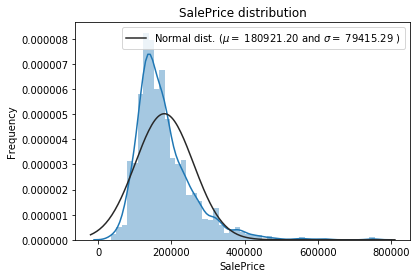

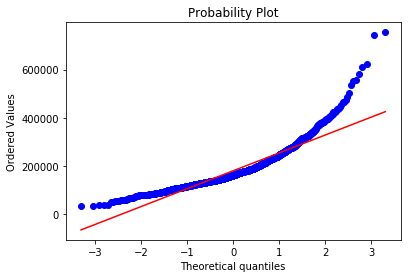

Skewness: 1.882876
Kurtosis: 6.536282


In [8]:
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Histogram
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Most of dwelling have a SalePrice between 80k and 280k

Looks like a normal distribution? Not quite! Looking at the kurtosis score, we can see that there is a very nice peak. </br>However, looking at the skewness score, we can see that the sale prices deviate from the normal distribution. </br>Going to have to fix this later! We want our data to be as "normal" as possible.

# Multivariable analysis

In [9]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64', 'float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 37 numerical = 80 features


Heatmap, just show correlation between numerical variable. We will print a Heatmap with 37 features

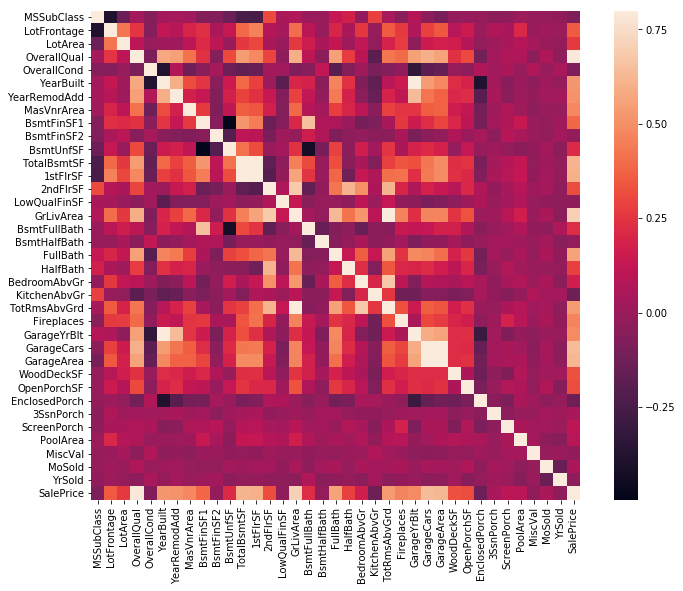

In [10]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

This overview is too difficult to understand. We will select the top 10 features most related to SalePrice.

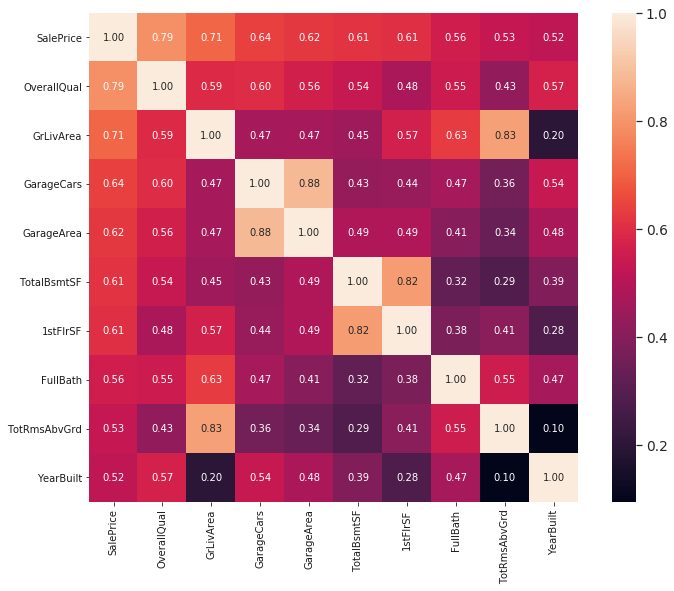

In [11]:
# Top 10 Heatmap
k = 10 # Number of features for the Heatmap
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [12]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most CorrelatedFeatures']
most_corr

,Most CorrelatedFeatures
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


Using "data_description.txt" Here are a description for all columns listed except SalePrice.

|Features|Description|
|--|--|
|OverallQual|Rates the overall material and finish of the house (1 = Very Poor, 10 = Very Excellent)|
|GrLivArea|Above grade (ground) living area square feet|
|GarageCars|Size of garage in car capacity|
|GarageArea|Size of garage in square feet|
|TotalBsmtSF|Total square feet of basement area|
|1stFlrSF|First Floor square feet|
|FullBath|Full bathrooms above grade|
|TotRmsAbvGrd|Total rooms above grade (does not include bathrooms)|
|YearBuilt|Original construction date|

We will look at each of them relates to Sale Price. And do some pre-cleaning. 

## Overall

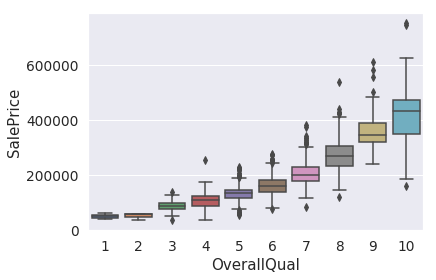

In [14]:
# Make boxplot
sns.boxplot(x=train['OverallQual'], y=train['SalePrice'])
plt.show()

Higher the quality of materials is, higher is the SalePrice. This seems normal.

# GrLivArea

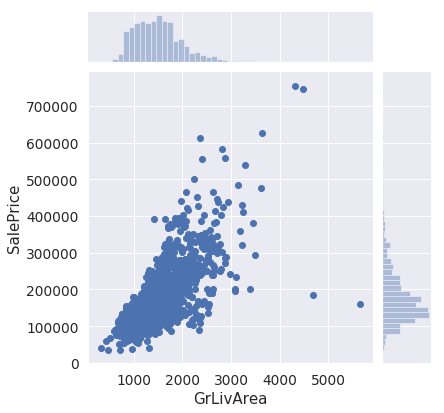

In [15]:
# Make jointplot
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.show()

Seems normal that people would pay more fore more living area. Two datapoints on the bottom right doesn't make sense.

We need to remove this outliers.

In [16]:
train = train.drop(train[(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index).reset_index(drop=True)

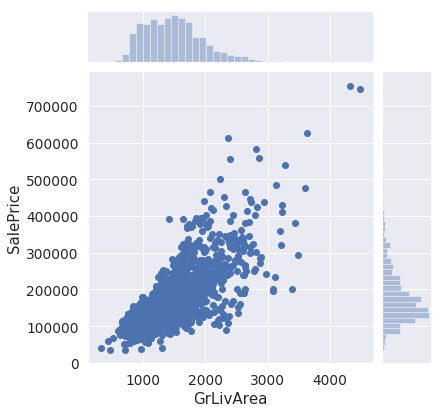

In [17]:
# Make jointplot
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.show()

## GarageCars

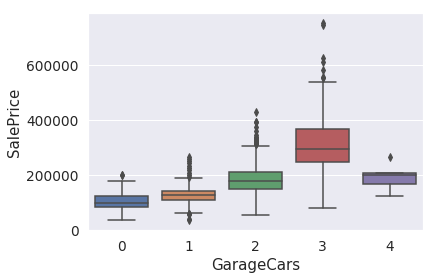

In [18]:
# Make boxplot
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])
plt.show()

Strange to buy a dwelling with a garage who can contain 4 cars cost less than a dwelling with a garage that can contain 3 cars. Let's remove them.

In [20]:
train = train.drop(train[(train['GarageCars']>3) & (train['SalePrice']<300000)].index).reset_index(drop=True)

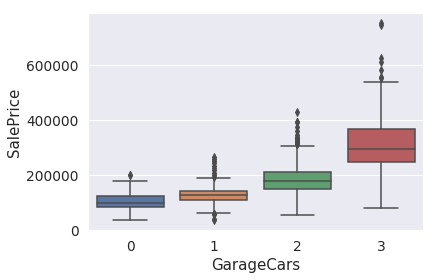

In [21]:
# Make boxplot
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])
plt.show()

## GarageArea

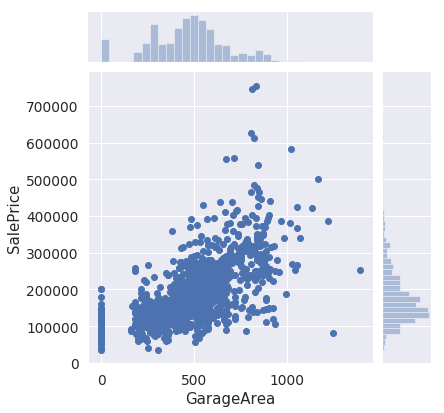

In [22]:
# Make jointplot
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'])
plt.show()

Again strange to have a garage with big area and low SalePrice.

In [23]:
# Removing outliers manually (More than 1000 sqft, less than $300k)
train = train.drop(train[(train['GarageArea']>1000) & (train['SalePrice']<300000)].index).reset_index(drop=True)

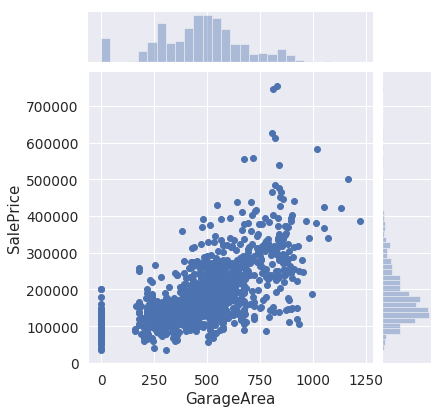

In [24]:
# Make jointplot
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'])
plt.show()

## TotalBsmtSF

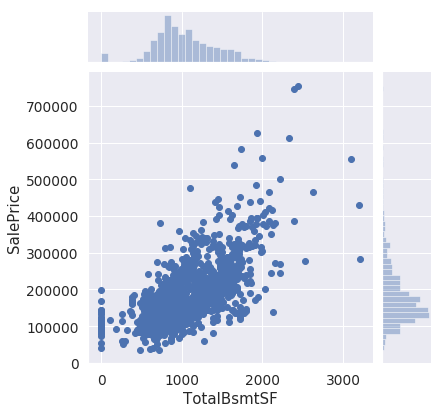

In [25]:
# Make jointplot
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'])
plt.show()

Everything looks fine here.

## 1stFlrSF

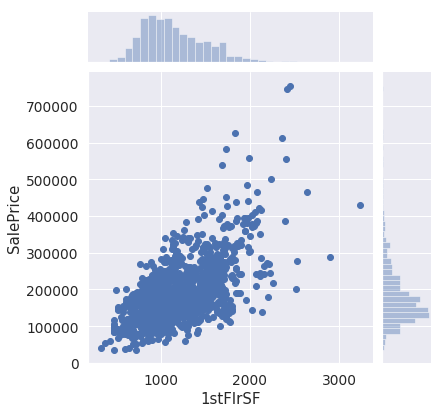

In [26]:
# Make jointplot
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'])
plt.show()

Seems good too.

## TotRmsAbvGrd

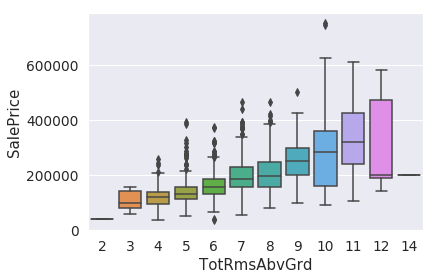

In [27]:
# Make boxplot
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])
plt.show()

Dataset contain only one dwelling with 14 rooms, this can affect the accuracy of the model, we need to delete this data. 

In [31]:
train = train.drop(train[train['TotRmsAbvGrd'] == 14].index).reset_index(drop=True)

## YearBuilt

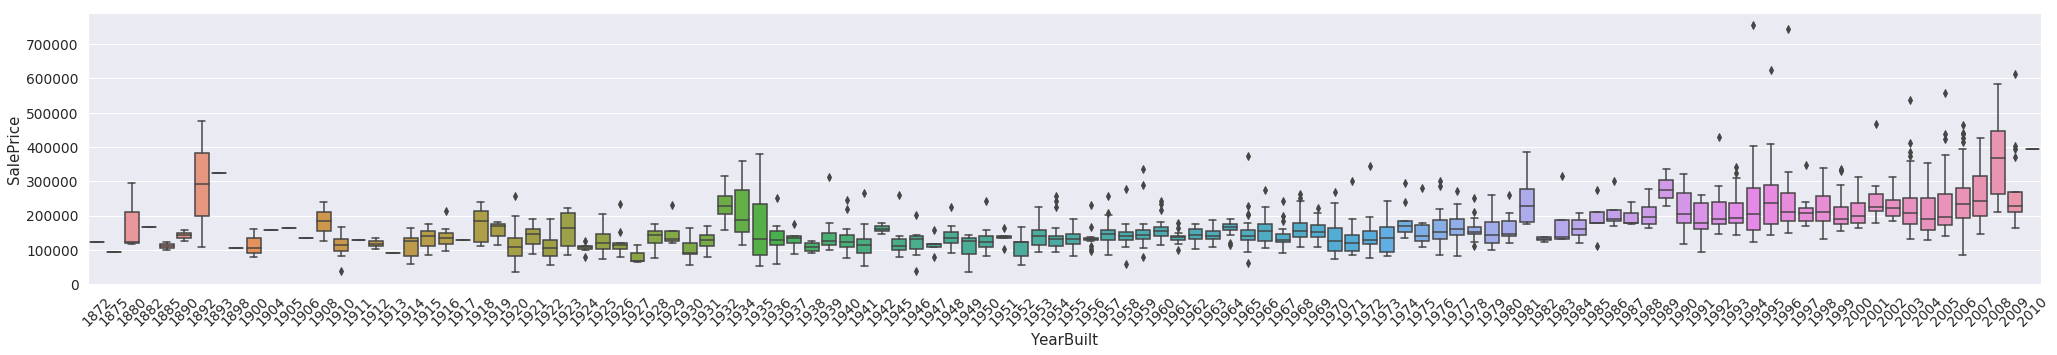

In [33]:
# Make boxplot
plt.figure(figsize=(35,5))
plt.xticks(rotation='45')
sns.boxplot(x=train['YearBuilt'], y=train['SalePrice'])
plt.show()

SalePrice seems to increase within time.

## Handle missing value

In [35]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (1447, 80)
Test data size is : (1459, 79)
Combined dataset size is : (2906, 79)


In [36]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.690296
MiscFeature,96.421198
Alley,93.255334
Fence,80.385409
FireplaceQu,48.692361
LotFrontage,16.689608
GarageFinish,5.437027
GarageYrBlt,5.437027
GarageQual,5.437027
GarageCond,5.437027


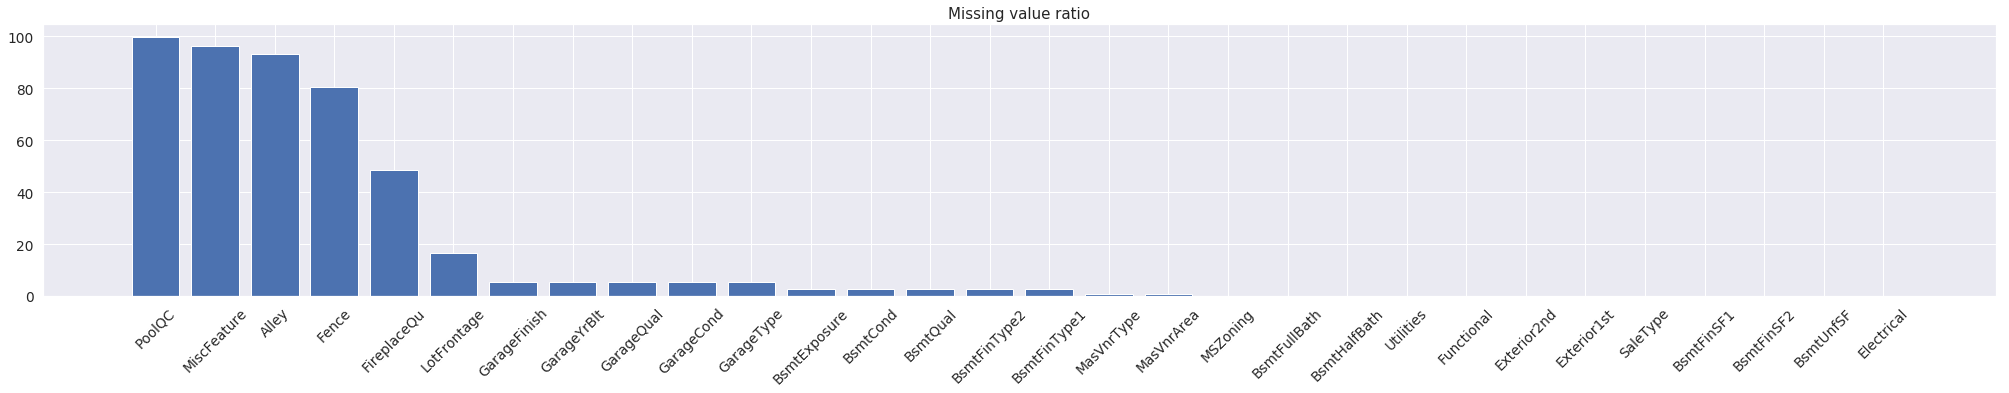

In [39]:
# Label of NaN feature
label = all_data_na.index

# ndarray of labels & and count of occurence of each labels
index = np.arange(len(label))
ratio = all_data_na

plt.figure(figsize=(35,5))

# Create bars
plt.bar(index, ratio)

# Create names on the x-axis
plt.xticks(index, label, rotation='45')
    
# Title of the plot
plt.title("Missing value ratio")

# Show graphic
plt.show()

**Imputing Missing Values**

- MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.
- LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
- Alley : data description says NA means "no alley access"
- Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
- Exterior1st and Exterior2nd : Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
- MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there isn't a basement.
- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: Replacing missing data with 0.
- Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
- KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
- Functional : data description says NA means typical.
- FireplaceQu : data description says NA means "no fireplace"
- GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with "None".
- GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0.
- PoolQC : data description says NA means "No Pool"
- Fence : data description says NA means "no fence"
- MiscFeature : data description says NA means "no misc feature"
- SaleType : Fill in again with most frequent which is "WD"

In [40]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
all_data['Alley'] = all_data['Alley'].fillna("None")
all_data = all_data.drop(['Utilities'], axis=1)
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna("None")
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna("None")
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Functional'] = all_data['Functional'].fillna("Typ")
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna("None")
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
all_data['PoolQC'] = all_data['PoolQC'].fillna("None")
all_data['Fence'] = all_data['Fence'].fillna("None")
all_data['MiscFeature'] = all_data['MiscFeature'].fillna("None")
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [41]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


# Feature Engineering

Some columns contains categorials value but there have numerical types. 
We need to change types of this features. 

In [42]:
#MSSubClass =The building class
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

Other features contains following value: 
    - Ex: Excellent
    - Gd: Good
    - TA: Typical/Average
    - Fa: Fair
    - Po: Poor

When exploring the data, it is difficult to immediatly understand the data and to know without "data_description.txt" if "Gd" is better than "TA".
Let's encode this data with a range of 1 to 5, 1 for Poor and 5 for Excellent.

In [43]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

Let's engineer one feature to combine square footage, this may be useful later on.

In [44]:
# Adding Total Square Feet feature 
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'])

# Adding Total bathrooms in the house. 1 = fullbath,0.5 = halfbath
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5*all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5*all_data['BsmtHalfBath']))

# Another combined variable is the total porch size
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF'])

In [45]:
#simplified features
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## Fixing "skewed" features

Here, we fix all of the skewed data to be more normal so that our models will be more accurate when making predictions.


 mu = 12.02 and sigma = 0.40



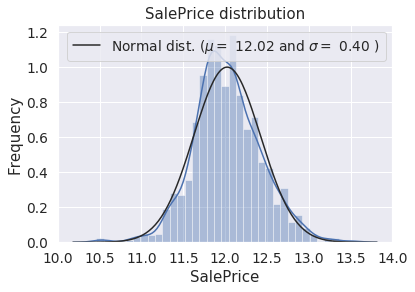

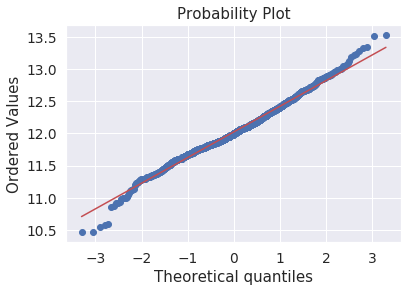

Skewness: 0.131041
Kurtosis: 0.821470


In [46]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

y_train = train.SalePrice.values

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [47]:
from scipy.stats import skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
MiscVal,21.907994
PoolArea,17.654963
haspool,15.465148
LotArea,13.145633
LowQualFinSF,12.379185


In [48]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lmbda = 0.15

for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lmbda)
    all_data[feat] += 1

There are 66 skewed numerical features to Box Cox transform


In [49]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2906, 227)


In [50]:
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
PoolArea,15.729427
haspool,15.465148
3SsnPorch,8.904182
LowQualFinSF,8.846052
MiscVal,5.615942


In [51]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modeling

## Import librairies

In [53]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Define a cross validation strategy

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [54]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Base models

- **LASSO Regression :**</br>
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [55]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression :**</br>
again made robust to outliers

In [56]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression :**</br>

In [57]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression :**</br>
With huber loss that makes it robust to outliers

In [58]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost :**

In [59]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

- **LightGBM :**

In [60]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## Base models scores

Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [61]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1116 (0.0075)



In [62]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0075)



In [63]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1147 (0.0074)



In [64]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1157 (0.0073)



In [65]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1156 (0.0056)



In [66]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1162 (0.0061)



## Stacking models

### Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)

### Averaged base models class

In [67]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

### Averaged base models score

We just average four models here **ENet, GBoost, KRR and lasso.** Of course we could easily add more models in the mix.



In [68]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1084 (0.0075)



### Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.</br>

The procedure, for the training part, may be described as follows:</br>

- Split the total training set into two disjoint sets (here **train** and **.holdout** )

- Train several base models on the first part (**train**)

- Test these base models on the second part (**holdout**)

- Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as **meta-features** on which, the final prediction is done with the meta-model.

### Stacking averaged Models Class



In [69]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

## Stacking Averaged models Score



To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [70]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1076 (0.0072)


We get again a better score by adding a meta learner

# Ensembling StackedRegressor, XGBoost and LightGBM

We add XGBoost and LightGBM to the StackedRegressor defined previously.

We first define a rmsle evaluation function

In [71]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## Final Training and Prediction

### StackedRegressor:

In [72]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07885321034271274


### XGBoost:

In [73]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.08075747329770352


### LightGBM:

In [74]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0709300459585002


In [75]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07581210572487587


### Ensemble prediction:

In [76]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

### Submission

In [77]:
ensemble

array([120277.63185055, 159367.22232948, 183482.87449753, ...,
       168841.39410572, 116449.74404919, 221019.09524099])